In [29]:
# General imports and widgets
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pixlc import plotting
import ipywidgets as widgets
from ipywidgets import interactive
from utils.transit import LinearTransit, LLDTransit, get_transit_model
from pixlc.plotting import plot_mozaic

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

# Project dir selection widget

project_button = widgets.Dropdown(
    options=[os.path.join('.'), # local git repo
             os.path.join('/','Users','Mario','mount_test','deepARTransit') # cobweb         
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

In [ ]:
from importlib import reload
import utils
reload(utils)
from utils import transit
reload(transit)
from utils.transit import LLDTransit


In [209]:
#project directory for loading the data
project_button

Dropdown(description='\t\t', index=1, options=('.', '/Users/Mario/mount_test/deepARTransit'), value='/Users/Ma…

In [50]:
# Experiment selection widget
project_dir = project_button.value

experiment_button = widgets.Dropdown(
    options=sorted(list({r.split('experiments')[1][1:] for r,d,f in os.walk(os.path.join(project_dir, 'deepartransit','experiments')) if 'output' in d and 'summary' in d})),
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

In [125]:
#Select an experime
experiment_button

Dropdown(description='\t\t', index=8, options=('cobweb/agol_all_artif_transits', 'cobweb/agol_all_artif_transi…

In [261]:
# Load data
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = experiment_button.value
#experiment_folder = 'cob£web/agol_rlc/22807296/'
experiment_dir = os.path.join(project_dir, 'deepartransit', 'experiments', experiment_folder)
print(experiment_dir)

config_file = get_config_file(experiment_dir)
config = process_config(config_file)
data = data_generator.DataGenerator(config)
config = data.update_config()
width = int(np.sqrt(data.Z.shape[0]))

transitModel = get_transit_model(config['transit_model'])
#os.listdir(os.path.join(project_dir, config.output_dir))

/Users/Mario/mount_test/deepARTransit/deepartransit/experiments/cobweb/agol_all_transits_r2
defaulting adapt range to True
defaulting stop adapt frac to 0.5
defaulting transit mode to linear
loading data from deepartransit/data/agol_transits_r2_nobacksub_full/rlc_agol_transits_r2.npy
(6, 690, 1) (6, 690, 2)
time_path parameter not found in config. Default to 0,1,2....T-1
Inferring num_features, num_cov, num_ts from the data.
selecting linear transit model


In [262]:
# retrieve evaluation steps
loc_dict = {}
pars_dict = {}
for fn in [s for s in os.listdir(os.path.join(project_dir, config.output_dir)) if (s[:3] == 'loc')]:
    step = fn.split('_')[-1].split('.')[0]
    try:
        loc_dict[int(step)] = np.load(os.path.join(project_dir, config.output_dir, fn)).swapaxes(0,1)#.mean(axis=0)
        pars_dict[int(step)] = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step))).swapaxes(0,1)
        
        #pred_instr = traces_array.mean(axis=(0))
        #length_pred = pred_instr.shape[1]
        #plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]
    except:
        print(fn)
        continue
step_list = sorted([int(k) for k in loc_dict if k!='array'])
print(step_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000]


In [263]:
# Visualize evolution of predictions and fits
pred_range = range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1)

def update(step = step_list[-1], obs = 0, show=True, verbose=True):
    loc_k = np.load(os.path.join(project_dir, config.output_dir, 'loc_array_{}.npy'.format(step))).swapaxes(0,1)
    scales_k = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).swapaxes(0,1)[obs].flatten()
    #print(loc_k.shape)
    trans_pars = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step)))
    try:
        popt = trans_pars[obs]
    except TypeError:
        popt = trans_pars
    transit = transitModel(data.time_array, popt)
    transit_component = (data.scaler_Z.inverse_transform(data.Z)[obs]
                         /data.scaler_Z.inverse_transform(loc_k)[obs])
    #print(transit_component.shape, scales_k.shape, data.Z.shape)
    #print(transit.transit_pars)
    transit.fit(transit_component, 
                range_fit=range(data.Z.shape[1]), 
                time_axis=0, 
                #p0=transit.transit_pars,
                sigma=scales_k)
    if verbose:
        print('transit params: {}'.format(popt))
        #print('uncertainties: {}'.format(transit.err))
        print('transit depth: {0:0.6f} +/- {1:0.6f}'.format(transit.delta, transit.err_delta))
        print('transit duration : {0:0.6f}'.format(transit.duration))
    plt.plot(data.Z[obs].flatten())
    plt.plot()
    p = plt.plot(loc_k[obs])
    plt.fill_between(data.time_array, loc_k[obs,:,0] - scales_k, loc_k[obs,:,0] + scales_k, alpha= 0.3, color=p[0].get_color())
    #plt.plot(pred_range, d[step][:,0,:,0].T, label=step, color='grey', linewidth=0.2, alpha= 0.3)
    #plt.plot(pred_range, d[step][:,0,:,0].mean(0), label=step, color='red', linewidth=1)
    #plt.plot(pred_range, data.scaler_Z.transform(data.scaler_Z.inverse_transform(d[step][:,0,:,0].mean(0)) *
    #                                             transit.flux[pred_range]).flatten(), 
    #         label=step, color='red', linewidth=1, alpha=0.7)
    
    
    plt.title('step {}'.format(step))
    if show:
        plt.show()

    plt.plot(transit_component)
    plt.plot(transit.flux, color='red')
    if show:
        plt.show()
    else:
        plt.clf()
    return np.sqrt(np.diag(transit.pcov))
    
def update_pixels(step = step_list[-1], obs=0):
    loc_k = np.load(os.path.join(project_dir, config.output_dir, 'loc_array_{}.npy'.format(step))).swapaxes(0,1)
    trans_pars = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step)))
    transit = transitModel(data.time_array, trans_pars[0])
    print('transit params: {}'.format(trans_pars[0]))
    scales_k = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).swapaxes(0,1)
    print(data.Z[obs].shape, loc_k.shape)
    #grid = plot_mozaic(data.Z[obs].reshape(-1, 1, 2), label='data')
    #plot_mozaic(loc_k[obs].reshape(-1, 2, 1), label='pred', grid=grid)
    #plt.show()
    #plt.plot(data.Z.sum(axis=(0, -1)))
    #plt.plot(loc_k.sum(axis=(0, -1)))
    #plt.show()
    plt.plot(data.scaler_Z.inverse_transform(data.Z).sum((0,-1)))
    #plt.plot(loc_k.sum(axis=(0, -1)))
    plt.plot(data.scaler_Z.inverse_transform(loc_k).sum((0,-1)))
    plt.show()
    plt.plot(data.scaler_Z.inverse_transform(data.Z).sum((0,-1))/
         data.scaler_Z.inverse_transform(loc_k).sum((0,-1)))
    plt.plot(transit.flux, color='red')
    plt.show()

if config.num_features - 1:  # Pixels mode
    interactive_plot = interactive(update_pixels, 
                                   step=(step_list[0], step_list[-1], config.freq_eval),
                                   obs=range(data.Z.shape[0]))
    output = interactive_plot.children[-1]
    output.layout.height = '1550px'
else:
    interactive_plot = interactive(update, 
                                   step=(step_list[0], step_list[-1], config.freq_eval),
                                   obs=range(data.Z.shape[0])
                                  )
    output = interactive_plot.children[-1]
    output.layout.height = '800px'

interactive_plot

interactive(children=(IntSlider(value=4000, description='step', max=4000, min=50, step=50), Dropdown(descripti…

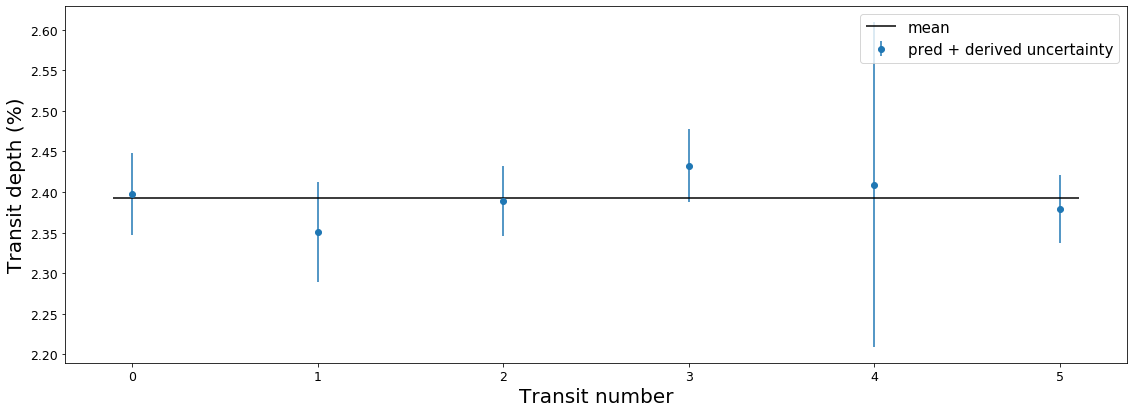

In [264]:
step = -1
power = 1 if config['transit_model'].lower() == 'linear' else 2

yerr = [update(obs=i, show=False, verbose=False)[1] for i in range(data.Z.shape[0])]

pars_array = np.array([pars_dict[step] for step in step_list])
plt.errorbar(range(data.Z.shape[0]), pars_array[step,1]**power*100, fmt='o', yerr=np.array(yerr)**power*100, label='pred + derived uncertainty')

#plt.hlines(0.015, 0,5, color='r', label='ground truth')
plt.hlines(np.mean(pars_array[step,1]**power)*100, -0.1, 5.1, label='mean')
plt.xlabel('Transit number', fontsize=20)
plt.ylabel('Transit depth (%)', rotation=90, fontsize=20)
plt.legend()
pass

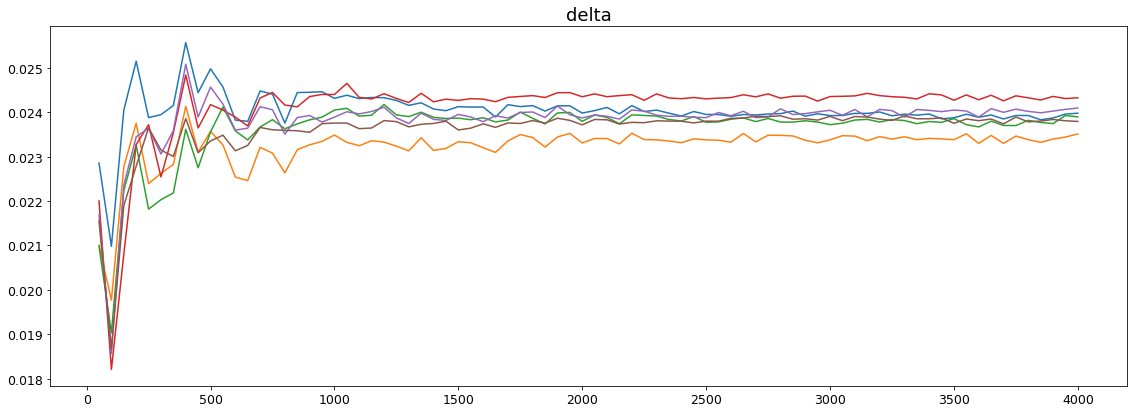

In [265]:
pars_array = np.array([pars_dict[step] for step in step_list])
plt.plot(step_list, pars_array[:,1]**power)
plt.title('delta')
plt.show()
#plt.plot(step_list, pars_array[:,0])
#plt.title('t_c')
#plt.show()
##plt.plot(step_list, pars_array[:,2])#
#plt.title('T')
#plt.show()
#plt.plot(step_list, pars_array[:,3])
#plt.title('tau')
#plt.legend()
#plt.show()
pass

In [266]:
transitModel = LLDTransit

transit depth:0.023628 +/- 0.000005
transit depth:0.023649 +/- 0.000005
transit depth:0.023959 +/- 0.000002
transit depth:0.024279 +/- 0.000003
transit depth:0.024487 +/- 0.000074
transit depth:0.023708 +/- 0.000008


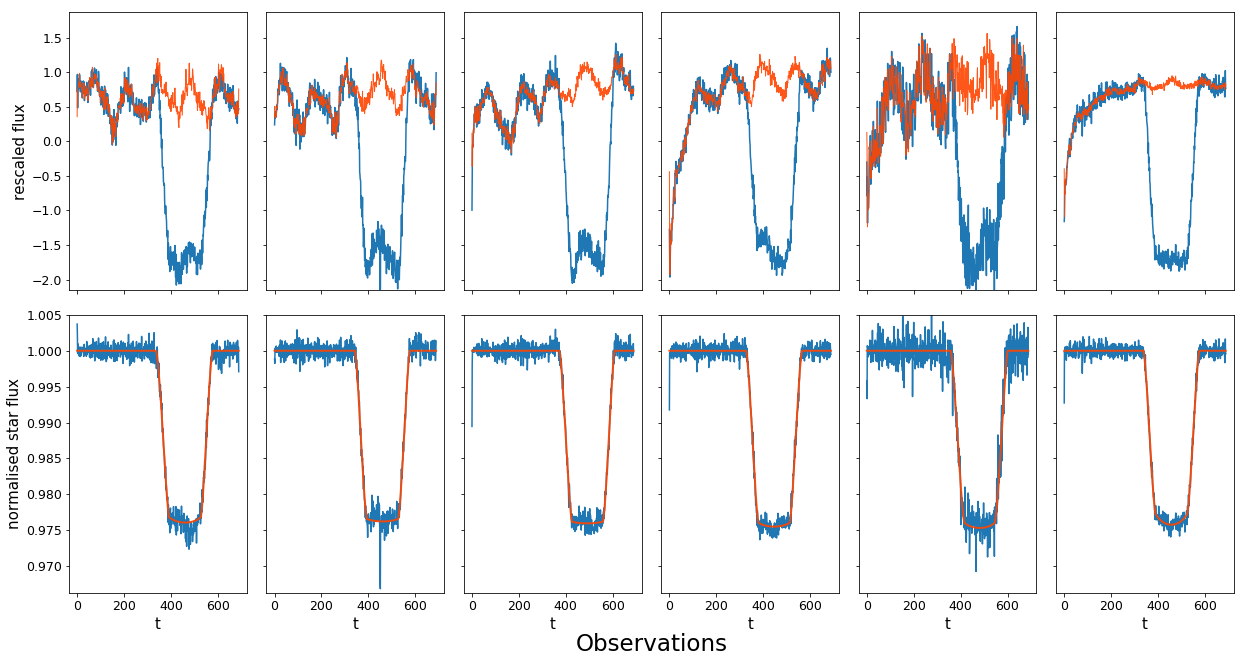

In [267]:
# all-transits in one plot
step = step_list[-1]
verbose=True

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
fig, ax = plt.subplots(2, data.Z.shape[0], figsize=(data.Z.shape[0]*3, 10), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0., wspace=0.)
if len(ax.shape) == 1:
    ax = ax[:,np.newaxis]
for obs in range(data.Z.shape[0]):
    
    
    loc_k = np.load(os.path.join(project_dir, config.output_dir, 'loc_array_{}.npy'.format(step))).swapaxes(0,1)
    scales_k = np.load(os.path.join(project_dir, config.output_dir, 'scales_array_{}.npy'.format(step))).swapaxes(0,1)[obs].flatten()
    #trans_pars = np.load(os.path.join(project_dir, config.output_dir, 'trans_pars_{}.npy'.format(step)))
    #try:
    #    popt = trans_pars[obs]
    #except TypeError:
    #    popt = trans_pars
    transit = transitModel(data.time_array)


    transit_component = (data.scaler_Z.inverse_transform(data.Z)[obs]
                         /data.scaler_Z.inverse_transform(loc_k)[obs])
    
    transit.fit(transit_component, 
                range_fit=range(data.Z.shape[1]), 
                time_axis=0, 
                p0=transit.transit_pars,
                sigma=scales_k)
    if verbose:
        #print('transit params: {}'.format(transit.transit_pars))
        #print('uncertainties: {}'.format(np.sqrt(np.diag(transit.pcov))))
        print('transit depth:{0:0.6f} +/- {1:0.6f}'.format(transit.delta, transit.err_delta))

    ax[0, obs].plot(data.Z[obs].flatten(), label='data')
    #plt.plot()
    p = ax[0, obs].plot(loc_k[obs], color='orangered', label='pred', linewidth=1, alpha=0.9)
    #ax[0, obs].fill_between(data.time_array, 
    #                   loc_k[obs,:,0] - scales_k, loc_k[obs,:,0] + scales_k, alpha= 0.3, 
    #                   color=p[0].get_color())
    #ax[0].set_xticks([])
    #plt.plot(pred_range, d[step][:,0,:,0].T, label=step, color='grey', linewidth=0.2, alpha= 0.3)
    #plt.plot(pred_range, d[step][:,0,:,0].mean(0), label=step, color='red', linewidth=1)
    #plt.plot(pred_range, data.scaler_Z.transform(data.scaler_Z.inverse_transform(d[step][:,0,:,0].mean(0)) *
    #                                             transit.flux[pred_range]).flatten(), 
    #         label=step, color='red', linewidth=1, alpha=0.7)


    #plt.title('step {}'.format(step))

    ax[1, obs].plot(transit_component)
    ax[1, obs].plot(transit.flux, color='orangered', label='best fit', linewidth=2, alpha=0.9)
    
    #ax[0,obs].legend()
    #ax[1,obs].legend()
    ax[1,obs].set_xlabel('t')
    

ax[0,0].set_ylabel('rescaled flux')
ax[1,0].set_ylabel('normalised star flux')
ax[0,0].set_ylim(np.mean(data.Z.min(axis=(1,2))))#, np.mean(data.Z.max(axis=(1,2)
ax[1,0].set_ylim( np.min(1 - transit.delta)-0.01, 1.005)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.margins(x = 1)
plt.xlabel("Observations", fontsize=23, labelpad=20)
plt.subplots_adjust(bottom=0.5)
fig.show()